In [ ]:
import os
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import librosa
import soundfile as sf
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


In [ ]:
import webrtcvad
import wave

#Chargement du data

In [ ]:

root_path ="/kaggle/working/librispeech-clean"
os.makedirs(root_path, exist_ok=True)

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="train-clean-100", download=True)


100%|██████████| 5.95G/5.95G [03:15<00:00, 32.6MB/s]


In [ ]:
test_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="test-clean", download=True)

100%|██████████| 331M/331M [00:18<00:00, 18.4MB/s]


#**Exploration de la base de données :**

**Chaque échantillon du dataset contient :**

waveform : Le signal audio sous forme d'un tenseur PyTorch.

sample_rate : La fréquence d'échantillonnage (normalement 16 kHz).

utterance : La transcription textuelle de l'audio.

speaker_id : L'identifiant du locuteur.

chapter_id : L'identifiant du chapitre d'où provient l'audio.

utterance_id : L'identifiant de la phrase.

# Exemple : speaker 0

In [ ]:
# Visulalize wavefrom
import matplotlib.pyplot as plt
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]

In [ ]:
import IPython.display as ipd
# lire et écouter un signal audio
ipd.Audio(waveform.numpy(), rate=sample_rate)

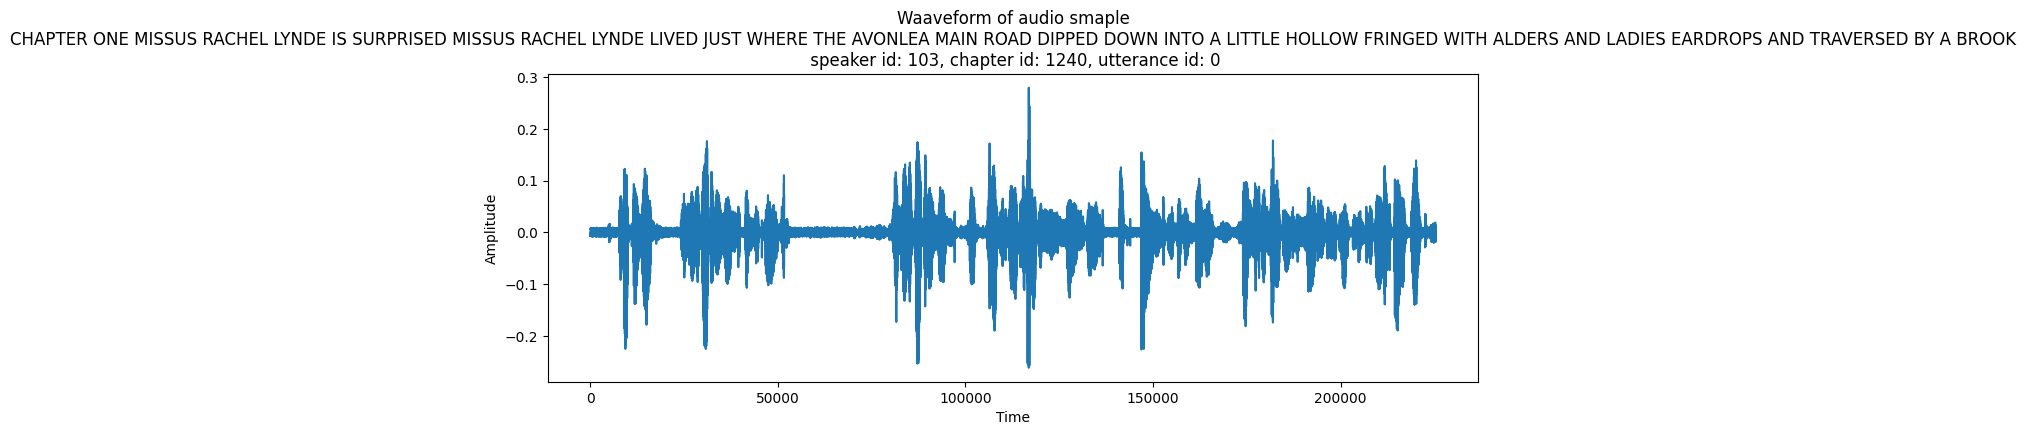

In [ ]:
# plot the waveform
plt.figure(figsize =(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waaveform of audio smaple\n{utterance}\n speaker id: {speaker_id}, chapter id: {chapter_id}, utterance id: {utterance_id}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# Extraire les IDs des locuteurs
speaker_ids = [str(train_dataset[i][3]) for i in range(len(train_dataset))]  # dataset[i][3] est l'ID du locuteur

# Nombre total de locuteurs uniques
df_speakers = pd.DataFrame(speaker_ids, columns=["speaker_id"])
total_speakers = df_speakers["speaker_id"].nunique()
print(f"Nombre total de locuteurs : {total_speakers}")


Nombre total de locuteurs : 251


Nombre de fichiers audio par locuteur :
speaker_id
103     102
1034     96
1040     81
1069    108
1081    130
       ... 
887     115
89      123
8975    115
909     110
911     113
Name: count, Length: 251, dtype: int64


<ipython-input-65-1ca0ce13bbe6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speaker_counts.index, y=speaker_counts.values, palette="viridis")


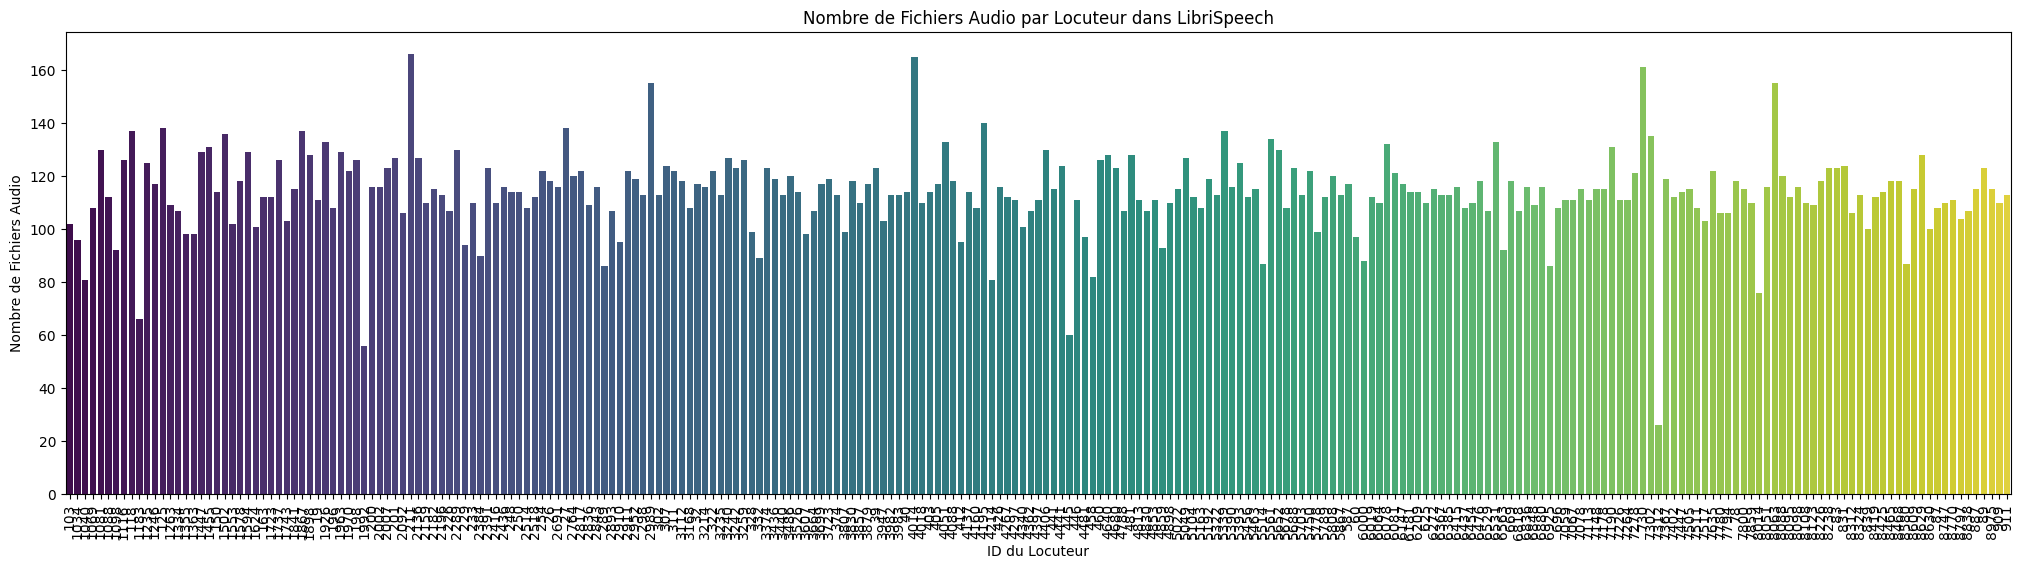

In [ ]:

# Créer un DataFrame et compter les occurrences des locuteurs
speaker_counts = df_speakers["speaker_id"].value_counts().sort_index()

# Afficher les statistiques
print("Nombre de fichiers audio par locuteur :")
print(speaker_counts)

# Tracer la distribution des fichiers audio par locuteur
plt.figure(figsize=(max(12, 0.1 * total_speakers), 6)) #figsize=(largeur, hauteur)
sns.barplot(x=speaker_counts.index, y=speaker_counts.values, palette="viridis")
plt.xlabel("ID du Locuteur")
plt.ylabel("Nombre de Fichiers Audio")
plt.title("Nombre de Fichiers Audio par Locuteur dans LibriSpeech")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Nombre min et max de fichiers audio par locuteur
min_files = speaker_counts.min()
max_files = speaker_counts.max()

print(f"Nombre minimum de fichiers audio par locuteur : {min_files}")
print(f"Nombre maximum de fichiers audio par locuteur : {max_files}")


Nombre minimum de fichiers audio par locuteur : 26
Nombre maximum de fichiers audio par locuteur : 166


Reconnaissance vocale : 16 kHz ou 22,05 kHz, car cela capture efficacement les fréquences pertinentes de la voix humaine sans être trop coûteux en termes de calcul

In [ ]:
sample_rate

16000

# Remarque
data base trop  **désequilibrée** => on va faire une selection les speakers qui ont au moins 100  audio files .


**Reconnaissance fermée (Closed-set classification) : où le modèle connaît tous les speakers en avance → plus d’audios par speaker est préférable**

 **Pourquoi plus d’audios par speaker est préférable ?**

Permet au modèle d’apprendre des variations naturelles dans la voix de chaque speaker (intonation, vitesse, bruit, etc.).

Réduit le risque d’overfitting sur un petit nombre d’échantillons qui ne représenteraient pas bien la voix du speaker.

Améliore la robustesse du modèle aux variations des conditions d’enregistrement (bruit de fond, micro différent, etc.).

 **Combien d’audios par speaker faut-il ?**

Deep Learning (CNN, RNN, Transformers) → Des dizaines voire centaines d’échantillons par speaker pour de bons résultats.

Approches classiques (MFCC + SVM, GMM, i-vectors) → Quelques dizaines peuvent suffire.



**I.Filtrage :**

In [ ]:
from collections import defaultdict , Counter

In [ ]:
#Dictionnaire pour compter les fichiers par speaker
speaker_counts = defaultdict(int)

# Parcourir le dataset pour compter les fichiers par speaker
for i in range(len(train_dataset)):
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[i]
    speaker_counts[speaker_id] += 1

# Filtrer les speakers avec au moins 100 fichiers audio
selected_speakers = [speaker for speaker, count in speaker_counts.items() if count >= 100]

print("Speakers avec au moins 100 fichiers audio :", selected_speakers)

Speakers avec au moins 100 fichiers audio : [103, 1069, 1081, 1088, 1116, 118, 1235, 1246, 125, 1263, 1334, 1447, 1455, 150, 1502, 1553, 1578, 1594, 1624, 163, 1723, 1737, 1743, 1841, 1867, 1898, 19, 1926, 196, 1963, 1970, 198, 200, 2002, 2007, 201, 2092, 211, 2136, 2159, 2182, 2196, 226, 2289, 233, 2391, 2416, 2436, 248, 250, 2514, 2518, 254, 26, 2691, 27, 2764, 2817, 2836, 2843, 2893, 2911, 2952, 298, 2989, 302, 307, 311, 3112, 3168, 32, 3214, 322, 3235, 3240, 3242, 3259, 3374, 3436, 3440, 3486, 3526, 3664, 3699, 3723, 374, 3830, 3857, 3879, 39, 3947, 3982, 3983, 40, 4014, 4018, 403, 405, 4051, 4088, 4137, 4160, 4195, 426, 4267, 4297, 4340, 4362, 4397, 4406, 441, 4441, 446, 460, 4640, 4680, 4788, 481, 4813, 4830, 4853, 4898, 5022, 5049, 5104, 5163, 5192, 5322, 5339, 5390, 5393, 5456, 5463, 5561, 5652, 5678, 5688, 5703, 5750, 5789, 5808, 5867, 587, 6019, 6064, 6078, 6081, 6147, 6181, 6209, 625, 6272, 6367, 6385, 6415, 6437, 6454, 6476, 6529, 6531, 669, 6818, 6836, 6848, 6880, 696, 705

In [ ]:
len(selected_speakers)

221

In [ ]:
#  le nombre total de fichiers après sélection
total_files_selected = sum(count for speaker, count in speaker_counts.items() if count >= 100)

print("Nombre total de fichiers audio après sélection :", total_files_selected)


Nombre total de fichiers audio après sélection : 25956


**II.Le nombre de fichiers audio que le plus grand nombre de speakers **

In [ ]:
# Étape 1 : Compter les fichiers par speaker
speaker_counts = defaultdict(int)
for i in range(len(train_dataset)):
    _, _, _, speaker_id, _, _ = train_dataset[i]
    speaker_counts[speaker_id] += 1

# Étape 2 : Compter combien de speakers ont chaque nombre de fichiers
file_count_distribution = Counter(speaker_counts.values())

# Étape 3 : Trouver le nombre de fichiers audio qui revient le plus chez les speakers
most_common_file_count, num_speakers = file_count_distribution.most_common(1)[0]

print(f"🎯 Le nombre de fichiers audio que le plus grand nombre de speakers ont est : {most_common_file_count}")
print(f"👥 Nombre de speakers ayant exactement {most_common_file_count} fichiers audio : {num_speakers}")

# Étape 4 : Liste des speakers concernés
target_speakers = [speaker for speaker, count in speaker_counts.items() if count == most_common_file_count]

print(f"🎯 Extraction des features pour les speakers avec exactement {most_common_file_count} fichiers audio")


🎯 Le nombre de fichiers audio que le plus grand nombre de speakers ont est : 113
👥 Nombre de speakers ayant exactement 113 fichiers audio : 15
🎯 Extraction des features pour les speakers avec exactement 113 fichiers audio


**III.Verifier d'autres Features :**

**On va travailler qu'avec les speakers déjà filtrés :**


1️⃣ Durée des fichiers audio

In [ ]:
# Dictionnaires pour stocker les durées des speakers sélectionnés
filtered_speaker_durations = defaultdict(float)

# Parcourir le dataset et ne traiter que les speakers sélectionnés
for i in range(len(train_dataset)):
    waveform, sample_rate, _, speaker_id, _, _ = train_dataset[i]

    if speaker_id in selected_speakers:  # Ne prendre que les speakers filtrés
        duration = waveform.shape[1] / sample_rate  # Durée en secondes
        filtered_speaker_durations[speaker_id] += duration

# Calculer la durée totale et la durée moyenne
total_duration_selected = sum(filtered_speaker_durations.values())
average_duration = total_duration_selected / total_files_selected if total_files_selected > 0 else 0

print("Durée totale des fichiers audio après sélection (en secondes) :", total_duration_selected)
print("Durée moyenne d'un fichier audio (en secondes) :", average_duration)


Durée totale des fichiers audio après sélection (en secondes) : 329227.9216875003
Durée moyenne d'un fichier audio (en secondes) : 12.684077734916794


# Interprétation

329,228 secondes ≈ 91.45 heures d’audio, ce qui est très bien pour un modèle de classification

12.68 secondes par fichier est largement suffisant pour capturer les caractéristiques vocales d’un speaker.

2️⃣ Qualité et diversité des enregistrements :

Methode 1 : observation des spectrograms :

<ipython-input-11-59c30d9426ba>:17: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


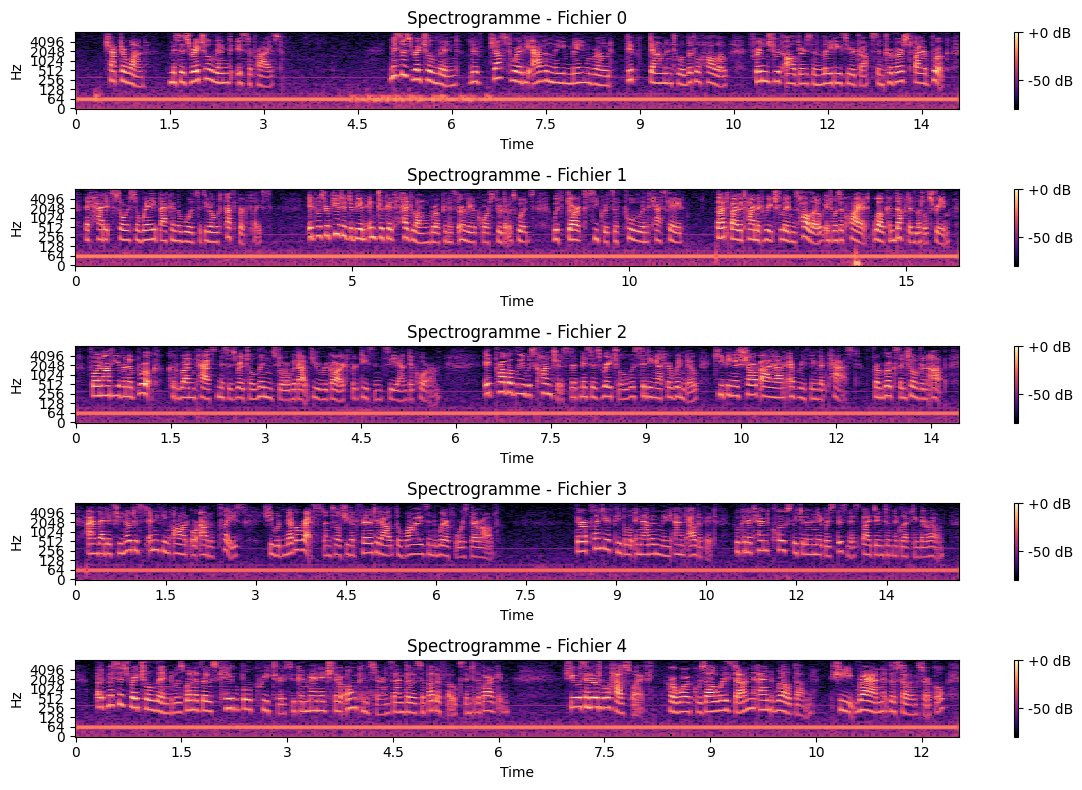

In [ ]:
# Nombre de spectrogrammes à afficher
num_spectrograms = 5

# Filtrer les fichiers pour ne garder que ceux des speakers sélectionnés
filtered_files = [i for i in range(len(train_dataset)) if train_dataset[i][3] in selected_speakers]

# Afficher quelques spectrogrammes des fichiers sélectionnés
plt.figure(figsize=(12, 8))

for idx, i in enumerate(filtered_files[:num_spectrograms]):  # Limiter à quelques fichiers pour l'affichage
    waveform, sample_rate, _, _, _, _ = train_dataset[i]

    y = waveform.numpy().flatten()  # Convertir en array NumPy
    sr = sample_rate

    # Calcul du spectrogramme
    spectrogram = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

    # Affichage
    plt.subplot(num_spectrograms, 1, idx + 1)
    librosa.display.specshow(spectrogram, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogramme - Fichier {i}")

plt.tight_layout()
plt.show()


1-**Silence :**

 zones noires (absence de signal) dans certains fichiers, notamment au milieu des spectrogramme :

* Des silences naturels dans le discours.
* Des coupures accidentelles dues à un mauvais traitement audio.

2- **Qualité du signal et bruit :**

* Les spectrogrammes montrent des formants bien définis, indiquant une bonne clarté de la parole.
* Il n’y a pas de présence visible de bruit de fond constant dans les basses fréquences (< 300 Hz), ce qui est un bon signe.
* Pas de saturation évidente (les bandes ne sont pas trop larges ni trop intenses).

3-**Cohérence entre les fichiers :**

* Tous les spectrogrammes ont une structure relativement similaire.
  


-> Uniformité des fichiers ???



Methode 2 :  **Rapport Signal/Bruit (SNR - Signal-to-Noise Ratio)**

In [ ]:
!pip install webrtcvad-wheels



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
# 🎯 Fonction pour calculer le SNR
def calculate_snr(waveform):
    rms_signal = np.sqrt(np.mean(waveform**2))
    noise = waveform - np.mean(waveform)
    rms_noise = np.sqrt(np.mean(noise**2))
    return 20 * np.log10(rms_signal / (rms_noise + 1e-10))


In [ ]:
# 📊 Tester quelques fichiers du dataset
num_files_to_test = 9  # Nombre de fichiers à analyser
for i in range(num_files_to_test):
    waveform, sample_rate, _, _, _, _ = train_dataset[i]
    waveform = waveform.numpy().flatten()

    # Calcul des métriques
    snr_value = calculate_snr(waveform)
    print(f"   - SNR: {snr_value:.2f} dB")

   - SNR: 0.00 dB
   - SNR: 0.00 dB
   - SNR: 0.00 dB
   - SNR: 0.00 dB
   - SNR: 0.00 dB
   - SNR: 0.00 dB
   - SNR: 0.00 dB
   - SNR: 0.00 dB
   - SNR: 0.00 dB


In [ ]:
# 🎯 Fonction pour calculer le SNR
def calculate_snr(waveform):
    rms_signal = np.sqrt(np.mean(waveform**2))
    noise = waveform - np.mean(waveform)
    rms_noise = np.sqrt(np.mean(noise**2))
    return 20 * np.log10(rms_signal / (rms_noise + 1e-10))

# 🎯 Fonction pour détecter l'activité vocale avec VAD
def check_audio_quality(file_path):
    vad = webrtcvad.Vad(3)  # Niveau d'agressivité (0 = moins strict, 3 = plus strict)
    with wave.open(file_path, "rb") as wf:
        audio = wf.readframes(wf.getnframes())
        return vad.is_speech(audio, wf.getframerate())

# 🎯 Fonction pour calculer la loudness (RMS)
def calculate_rms(waveform):
    return np.sqrt(np.mean(waveform**2))

# 📊 Tester quelques fichiers du dataset
num_files_to_test = 5  # Nombre de fichiers à analyser
for i in range(num_files_to_test):
    waveform, sample_rate, _, _, _, _ = train_dataset[i]  # Charger l'audio
    waveform = waveform.numpy().flatten()  # Convertir en format numpy

    # Calcul des métriques
    snr_value = calculate_snr(waveform)
    rms_value = calculate_rms(waveform)

    print(f"🔹 Audio {i+1}:")
    print(f"   - SNR: {snr_value:.2f} dB")
    print(f"   - RMS Loudness: {rms_value:.4f}")



🔹 Audio 1:
   - SNR: 0.00 dB
   - RMS Loudness: 0.0230
🔹 Audio 2:
   - SNR: 0.00 dB
   - RMS Loudness: 0.0266
🔹 Audio 3:
   - SNR: 0.00 dB
   - RMS Loudness: 0.0298
🔹 Audio 4:
   - SNR: 0.00 dB
   - RMS Loudness: 0.0284
🔹 Audio 5:
   - SNR: 0.00 dB
   - RMS Loudness: 0.0275


#Silencce :

In [ ]:
# Fonction pour détecter et supprimer les silences
def remove_silence(audio, top_db=25):
    # Utiliser librosa.effects.trim pour couper les silences
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)
    return trimmed_audio

Traitement de 25956 fichiers audio après filtrage des speakers...
top_db=10 -> Durée moyenne après suppression: 90.29% de la durée originale
top_db=15 -> Durée moyenne après suppression: 93.11% de la durée originale
top_db=20 -> Durée moyenne après suppression: 94.23% de la durée originale
top_db=25 -> Durée moyenne après suppression: 94.99% de la durée originale
top_db=30 -> Durée moyenne après suppression: 95.74% de la durée originale


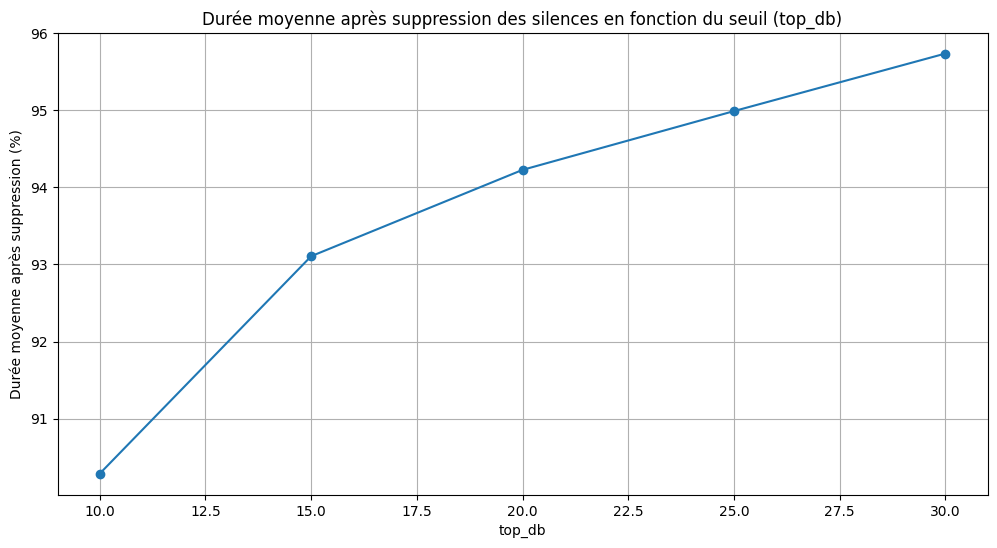

In [ ]:
# Fonction pour calculer la durée après suppression des silences
def get_duration_after_silence_removal(audio, sr, top_db):
    trimmed_audio = remove_silence(audio, top_db)
    return len(trimmed_audio) / sr

# Tester différentes valeurs de top_db
top_db_values = [10, 15, 20, 25, 30]
durations_after_removal = {top_db: [] for top_db in top_db_values}

# Filtrer les fichiers pour ne garder que ceux des speakers sélectionnés
filtered_files = [i for i in range(len(train_dataset)) if train_dataset[i][3] in selected_speakers]

total_files = len(filtered_files)
print(f"Traitement de {total_files} fichiers audio après filtrage des speakers...")

# Boucler uniquement sur les fichiers des speakers sélectionnés
for i in filtered_files:
    waveform, sample_rate, _, speaker_id, _, _ = train_dataset[i]  # Charger un fichier audio
    y = waveform.numpy().flatten()
    original_duration = len(y) / sample_rate

    for top_db in top_db_values:
        duration_after_removal = get_duration_after_silence_removal(y, sample_rate, top_db)
        durations_after_removal[top_db].append(duration_after_removal / original_duration * 100)

# Calculer la moyenne des durées après suppression
duration_means = {top_db: np.mean(durations) for top_db, durations in durations_after_removal.items()}

# Afficher les résultats
for top_db, mean_duration in duration_means.items():
    print(f"top_db={top_db} -> Durée moyenne après suppression: {mean_duration:.2f}% de la durée originale")

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(top_db_values, list(duration_means.values()), marker='o')
plt.title("Durée moyenne après suppression des silences en fonction du seuil (top_db)")
plt.xlabel("top_db")
plt.ylabel("Durée moyenne après suppression (%)")
plt.grid(True)
plt.show()

Avec top_db = 10, il reste 90.31 % de la durée originale.

→ Cela signifie que 9.69 % de l’audio a été supprimé (des silences).

Avec top_db = 30, il reste 95.83 % de la durée originale.

→ Ici, seulement 4.17 % de l’audio a été supprimé.


#Extraction

#avec tous les locuteurs

# **I. Train_dataset**

In [ ]:
print(train_dataset[0])

(tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]]), 16000, 'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK', 103, 1240, 0)


(
    tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]]),  # 1️⃣ Signal audio
    16000,  # 2️⃣ Fréquence d'échantillonnage
    'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED ...',  # 3️⃣ Transcription du texte
    103,  # 4️⃣ speaker_id (ID du locuteur)
    1240, # 5️⃣ chapter_id (ID du chapitre)
    0  # 6️⃣ utterance_id (ID de l'extrait audio dans ce chapitre)
)

In [ ]:



# Fonction pour extraire les features
def extract_features(audio, sr):
    try:
        # Vérifier que l'audio n'est pas vide
        if len(audio) == 0:
            warnings.warn("Audio vide détecté, features non extraites.")
            return None

        # MFCCs (13 coefficients)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        spectral_centroid_mean = np.mean(spectral_centroid)

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        zcr_mean = np.mean(zcr)

        # Chroma
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Concaténer tous les features
        feature_vector = np.concatenate([mfcc_mean, [spectral_centroid_mean], [zcr_mean], chroma_mean])

        return feature_vector

    except Exception as e:
        warnings.warn(f"⚠️ Erreur lors de l'extraction des features : {e}")
        return None

# Initialiser les listes de stockage
features = []
labels = []

# Boucle sur les fichiers du dataset
for idx in range(len(train_dataset)):
    try:
        # Charger l'audio et les métadonnées
        waveform, sample_rate, _, speaker_id,_, _ = train_dataset[idx]

        # Vérifier la validité de l'audio
        if waveform.numel() == 0:
            warnings.warn(f"⚠️ Audio vide à l'index {idx}")
            continue

        # Convertir en numpy
        y = waveform.numpy().flatten()

        # Supprimer les silences
        y_trimmed = remove_silence(y)

        # Extraire les features
        feature_vector = extract_features(y_trimmed, sample_rate)

        # Vérifier si les features ont bien été extraites
        if feature_vector is not None and feature_vector.shape[0] == 27:  # 13 MFCC + 1 SC + 1 ZCR + 12 Chroma
            features.append(feature_vector)
            labels.append(speaker_id)  # Utiliser l'ID du locuteur ici

    except Exception as e:
        warnings.warn(f"⚠️ Erreur lors du traitement du fichier à l'index {idx}: {e}")
        continue

# Vérifier qu'on a bien extrait des features avant d'enregistrer
if len(features) > 0:
    # Définir les noms des colonnes
    mfcc_columns = [f"mfcc_mean_{i+1}" for i in range(13)]
    chroma_columns = [f"chroma_mean_{i+1}" for i in range(12)]

    # Création du DataFrame avec les noms des features
    column_names = mfcc_columns + ["spectral_centroid_mean", "zcr_mean"] + chroma_columns + ["speaker_id"]

    # Création du DataFrame
    df = pd.DataFrame(features, columns=column_names[:-1])
    df["speaker_id"] = labels  # Associer les labels des locuteurs

    # Sauvegarde en CSV
    df.to_csv("extracted_features.csv", index=False)
    print("✅ Extraction des features terminée. Résultats enregistrés dans 'extracted_features.csv'")
else:
    print("❌ Aucune feature extraite. Vérifiez les fichiers audio.")




/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


✅ Extraction des features terminée. Résultats enregistrés dans 'extracted_features.csv'


In [ ]:
# Vérification de la répartition des locuteurs
locuteur_counts = df['speaker_id'].value_counts()
print(locuteur_counts)

speaker_id
211     166
4014    165
730     161
8063    155
2989    155
       ... 
8014     76
1183     66
445      60
1992     56
7312     26
Name: count, Length: 251, dtype: int64


In [ ]:
# Vérification du nombre d'échantillons par locuteur
locuteurs_count = df['speaker_id'].value_counts()
locuteurs_count[locuteurs_count == 1]

,count
speaker_id,


In [ ]:
df.describe()

,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12,speaker_id
count,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,...,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000,28539.000000
mean,-290.090953,82.242296,-2.210152,26.906808,-3.586185,-1.898726,-8.503051,-6.989741,-3.259414,-3.625006,...,0.336386,0.344022,0.361687,0.376616,0.389401,0.397826,0.404164,0.410409,0.403684,3807.547216
std,41.478366,25.275481,16.005134,12.528874,11.408379,10.030210,9.208095,8.669922,7.043430,6.281733,...,0.082510,0.078525,0.077761,0.077951,0.078620,0.079622,0.079190,0.079838,0.084808,2780.342240
min,-526.598999,-16.723074,-78.507256,-31.046173,-54.240986,-44.151031,-46.989956,-39.301369,-33.242237,-35.413086,...,0.052429,0.040199,0.035435,0.048366,0.076497,0.077723,0.114559,0.099926,0.063305,19.000000
25%,-315.328827,65.898071,-12.700506,19.610894,-10.443148,-8.046662,-14.415640,-12.758675,-7.898104,-7.823501,...,0.281300,0.292476,0.309370,0.324053,0.337680,0.345211,0.350507,0.356343,0.348390,1116.000000
50%,-288.866699,85.161858,-1.902283,27.214325,-3.133798,-1.271702,-7.584505,-6.607929,-2.607620,-3.692103,...,0.334318,0.342397,0.360719,0.376459,0.389290,0.397731,0.404186,0.411032,0.401001,3664.000000
75%,-262.993958,99.167969,8.609413,34.695684,3.814608,4.836279,-2.048234,-1.081802,1.720728,0.684402,...,0.390910,0.395483,0.413196,0.428326,0.441584,0.450359,0.458080,0.462832,0.454840,6181.000000
max,-74.082283,170.253677,58.882744,95.340736,38.821922,29.987885,21.479652,18.957453,21.713921,23.942820,...,0.706064,0.700180,0.694810,0.716522,0.724507,0.739668,0.813386,0.912993,0.961119,8975.000000


In [ ]:
df


,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12,speaker_id
0,-333.317566,50.116344,0.069278,30.312616,-1.033282,0.725147,-11.650712,4.119285,3.176247,1.745105,...,0.232160,0.185734,0.196670,0.206052,0.277468,0.415447,0.456836,0.473299,0.545408,103
1,-298.255127,50.996006,-8.168121,32.077904,-6.062384,-2.851641,-16.293848,2.072382,0.899045,0.794943,...,0.267001,0.251560,0.279555,0.292389,0.299462,0.384361,0.439184,0.387917,0.482688,103
2,-289.472321,54.571869,-15.992660,31.522797,-5.027257,-2.870338,-16.374199,1.417096,3.128462,0.252196,...,0.217650,0.264352,0.309357,0.319234,0.396581,0.421712,0.405161,0.422715,0.476324,103
3,-298.096283,57.274349,-12.667687,32.944469,-9.421248,-8.878465,-13.460402,8.440254,0.546331,0.683379,...,0.225665,0.249316,0.251276,0.300225,0.378014,0.360848,0.354514,0.438330,0.510245,103
4,-300.586426,58.328205,-5.300399,28.057859,-10.838979,-11.008667,-11.948786,7.194673,-1.596195,3.708319,...,0.301525,0.284762,0.266036,0.288625,0.346093,0.377580,0.341804,0.370438,0.452507,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28534,-297.504028,92.721603,-26.162539,27.721846,-17.616207,-6.319375,-21.522253,-18.606705,-0.992417,-20.245613,...,0.294912,0.285803,0.349510,0.503949,0.545909,0.430670,0.404517,0.449435,0.396268,911
28535,-401.941742,97.691849,-19.207779,22.522438,-11.462331,-8.070600,-13.576226,-11.761776,-0.597179,-16.846867,...,0.410919,0.390141,0.444728,0.535307,0.627280,0.559598,0.467033,0.411069,0.401373,911
28536,-361.874329,96.251549,-18.495451,16.325739,-9.978543,-6.689950,-14.944684,-16.979944,1.618641,-17.544832,...,0.363179,0.354754,0.388835,0.545458,0.589446,0.521651,0.405276,0.335217,0.312621,911
28537,-341.771332,83.448830,-13.465381,23.734880,-13.090948,-6.440833,-15.758504,-13.525767,-2.398408,-18.736095,...,0.329645,0.316195,0.380669,0.502936,0.610506,0.501798,0.425516,0.375036,0.360777,911


,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12,speaker_id
0,-333.317566,50.116344,0.069278,30.312616,-1.033282,0.725147,-11.650712,4.119285,3.176247,1.745105,...,0.232160,0.185734,0.196670,0.206052,0.277468,0.415447,0.456836,0.473299,0.545408,103
1,-298.255127,50.996006,-8.168121,32.077904,-6.062384,-2.851641,-16.293848,2.072382,0.899045,0.794943,...,0.267001,0.251560,0.279555,0.292389,0.299462,0.384361,0.439184,0.387917,0.482688,103
2,-289.472321,54.571869,-15.992660,31.522797,-5.027257,-2.870338,-16.374199,1.417096,3.128462,0.252196,...,0.217650,0.264352,0.309357,0.319234,0.396581,0.421712,0.405161,0.422715,0.476324,103
3,-298.096283,57.274349,-12.667687,32.944469,-9.421248,-8.878465,-13.460402,8.440254,0.546331,0.683379,...,0.225665,0.249316,0.251276,0.300225,0.378014,0.360848,0.354514,0.438330,0.510245,103
4,-300.586426,58.328205,-5.300399,28.057859,-10.838979,-11.008667,-11.948786,7.194673,-1.596195,3.708319,...,0.301525,0.284762,0.266036,0.288625,0.346093,0.377580,0.341804,0.370438,0.452507,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28534,-297.504028,92.721603,-26.162539,27.721846,-17.616207,-6.319375,-21.522253,-18.606705,-0.992417,-20.245613,...,0.294912,0.285803,0.349510,0.503949,0.545909,0.430670,0.404517,0.449435,0.396268,911
28535,-401.941742,97.691849,-19.207779,22.522438,-11.462331,-8.070600,-13.576226,-11.761776,-0.597179,-16.846867,...,0.410919,0.390141,0.444728,0.535307,0.627280,0.559598,0.467033,0.411069,0.401373,911
28536,-361.874329,96.251549,-18.495451,16.325739,-9.978543,-6.689950,-14.944684,-16.979944,1.618641,-17.544832,...,0.363179,0.354754,0.388835,0.545458,0.589446,0.521651,0.405276,0.335217,0.312621,911
28537,-341.771332,83.448830,-13.465381,23.734880,-13.090948,-6.440833,-15.758504,-13.525767,-2.398408,-18.736095,...,0.329645,0.316195,0.380669,0.502936,0.610506,0.501798,0.425516,0.375036,0.360777,911


In [ ]:
df.shape

In [ ]:
# Vérification du nombre d'échantillons par locuteur
locuteurs_counts = df['speaker_id'].value_counts()
locuteurs_counts[locuteurs_counts == 1]


In [ ]:
locuteurs_counts

,count
speaker_id,
211,166
4014,165
730,161
8063,155
2989,155
...,...
8014,76
1183,66
445,60


In [ ]:
locuteurs_counts.unique()

array([166, 165, 161, 155, 140, 138, 137, 136, 135, 134, 133, 132, 131,
       130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118,
       117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 104,
       103, 102, 101, 100,  99,  98,  97,  96,  95,  94,  93,  92,  90,
        89,  88,  87,  86,  82,  81,  76,  66,  60,  56,  26])

In [ ]:
#Checking for missing values
print(df.isnull().sum())

mfcc_mean_1               0
mfcc_mean_2               0
mfcc_mean_3               0
mfcc_mean_4               0
mfcc_mean_5               0
mfcc_mean_6               0
mfcc_mean_7               0
mfcc_mean_8               0
mfcc_mean_9               0
mfcc_mean_10              0
mfcc_mean_11              0
mfcc_mean_12              0
mfcc_mean_13              0
spectral_centroid_mean    0
zcr_mean                  0
chroma_mean_1             0
chroma_mean_2             0
chroma_mean_3             0
chroma_mean_4             0
chroma_mean_5             0
chroma_mean_6             0
chroma_mean_7             0
chroma_mean_8             0
chroma_mean_9             0
chroma_mean_10            0
chroma_mean_11            0
chroma_mean_12            0
speaker_id                0
dtype: int64


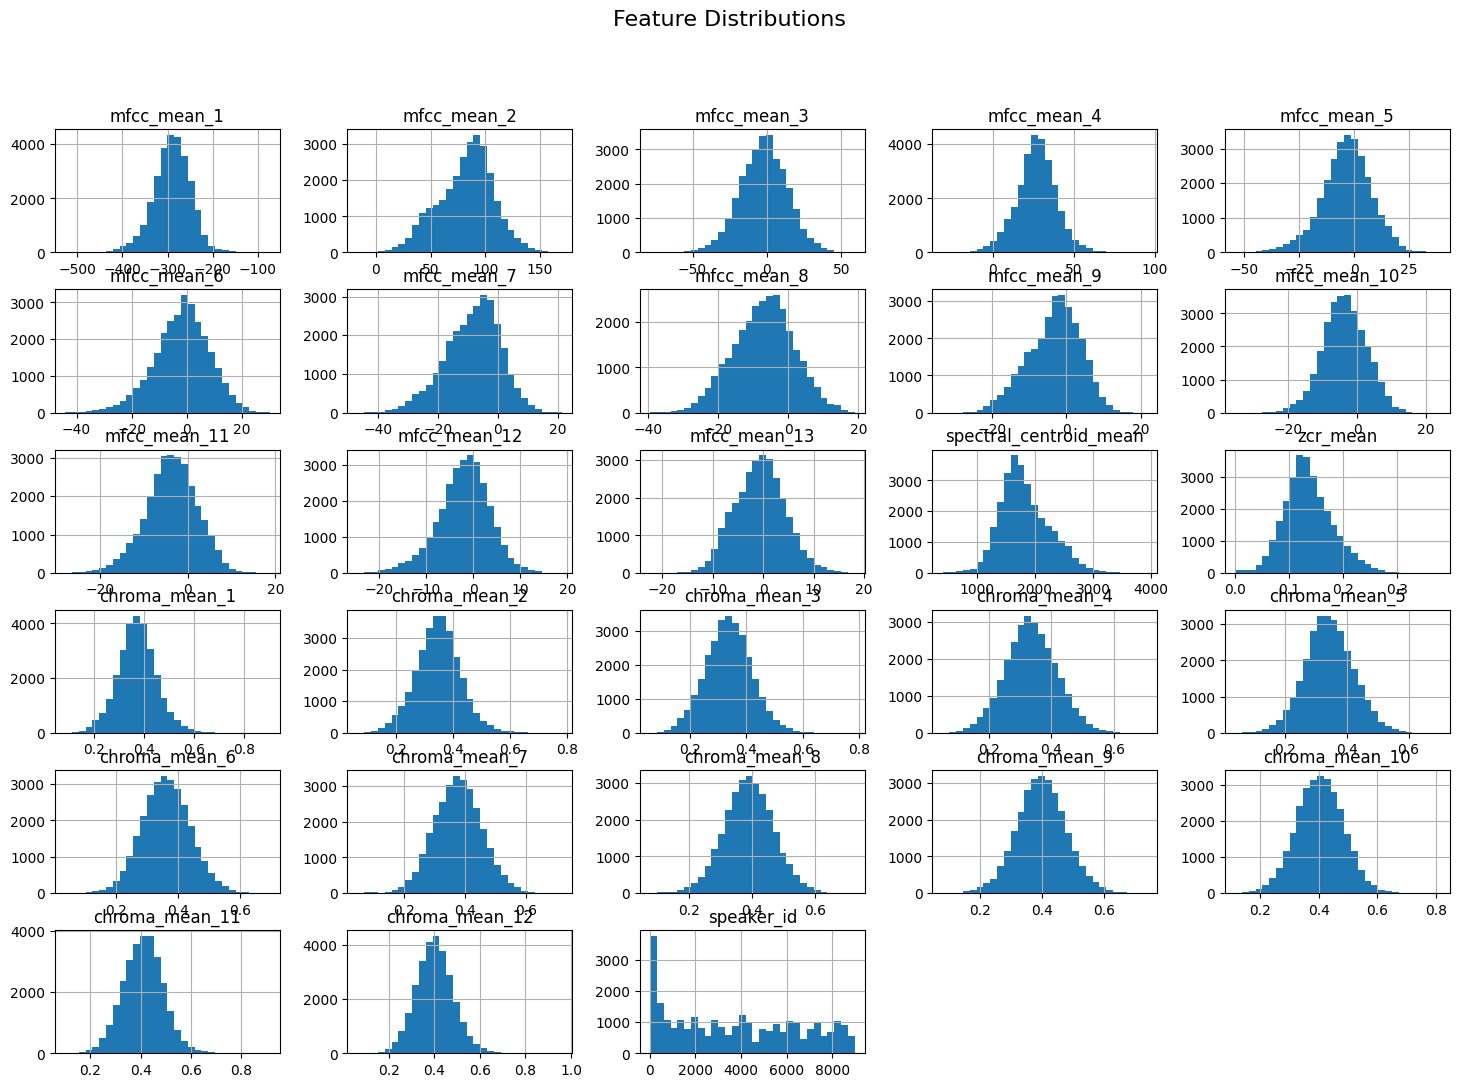

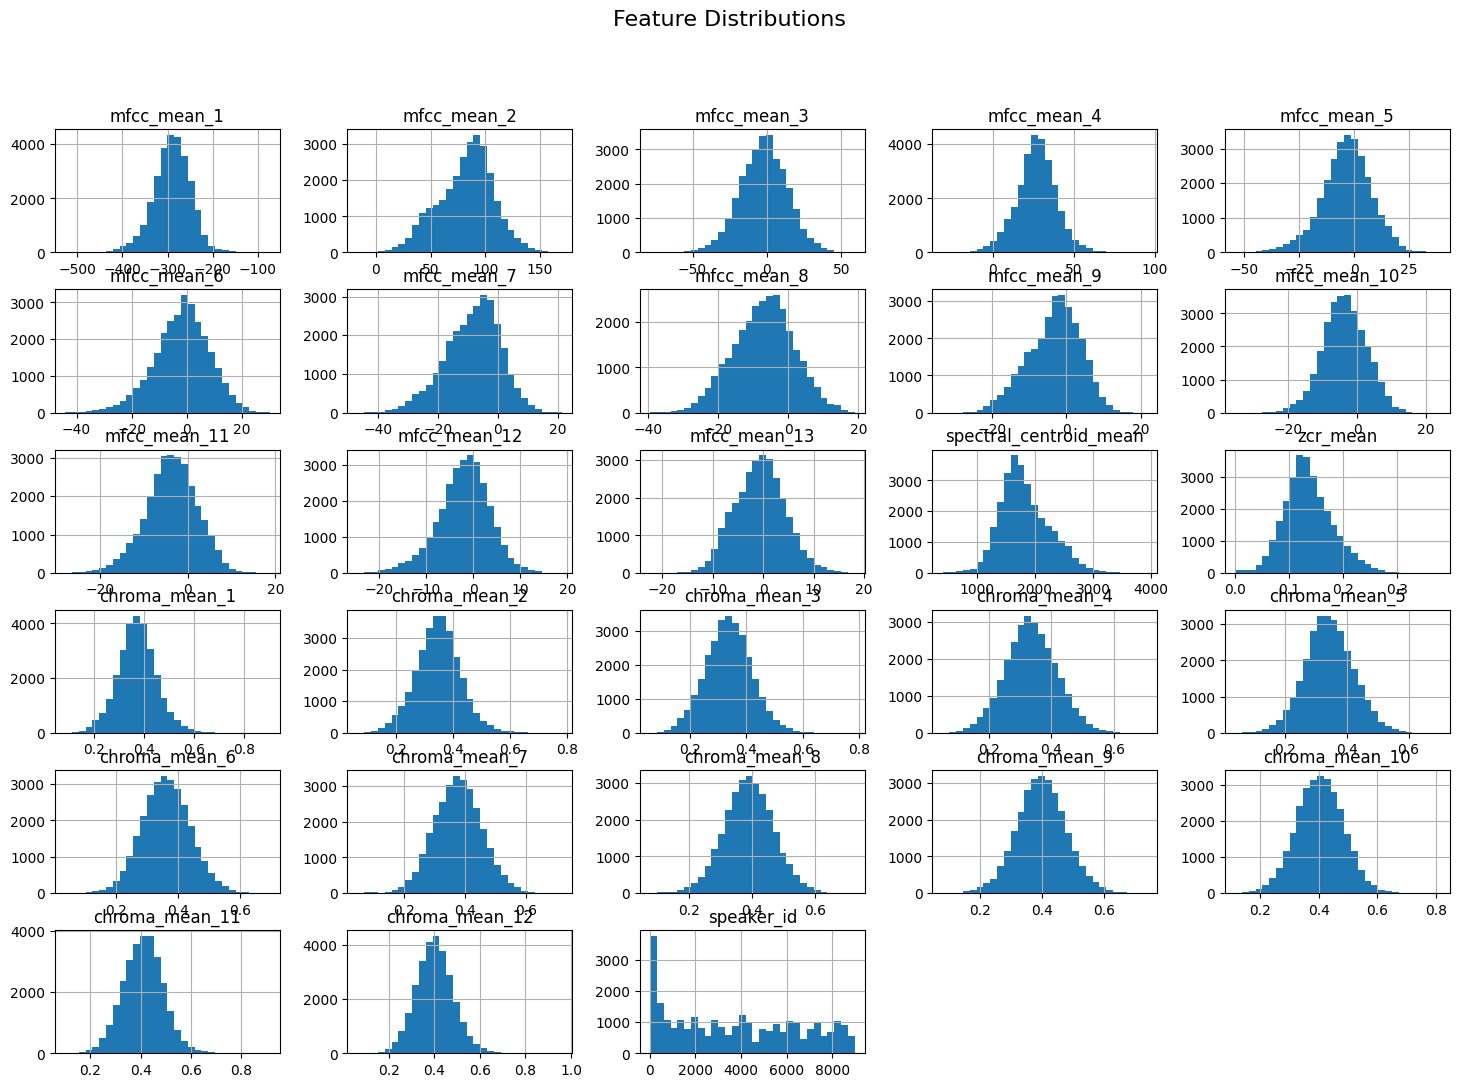

In [ ]:
#Checking the feature distributions


df.hist(figsize=(18, 12), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

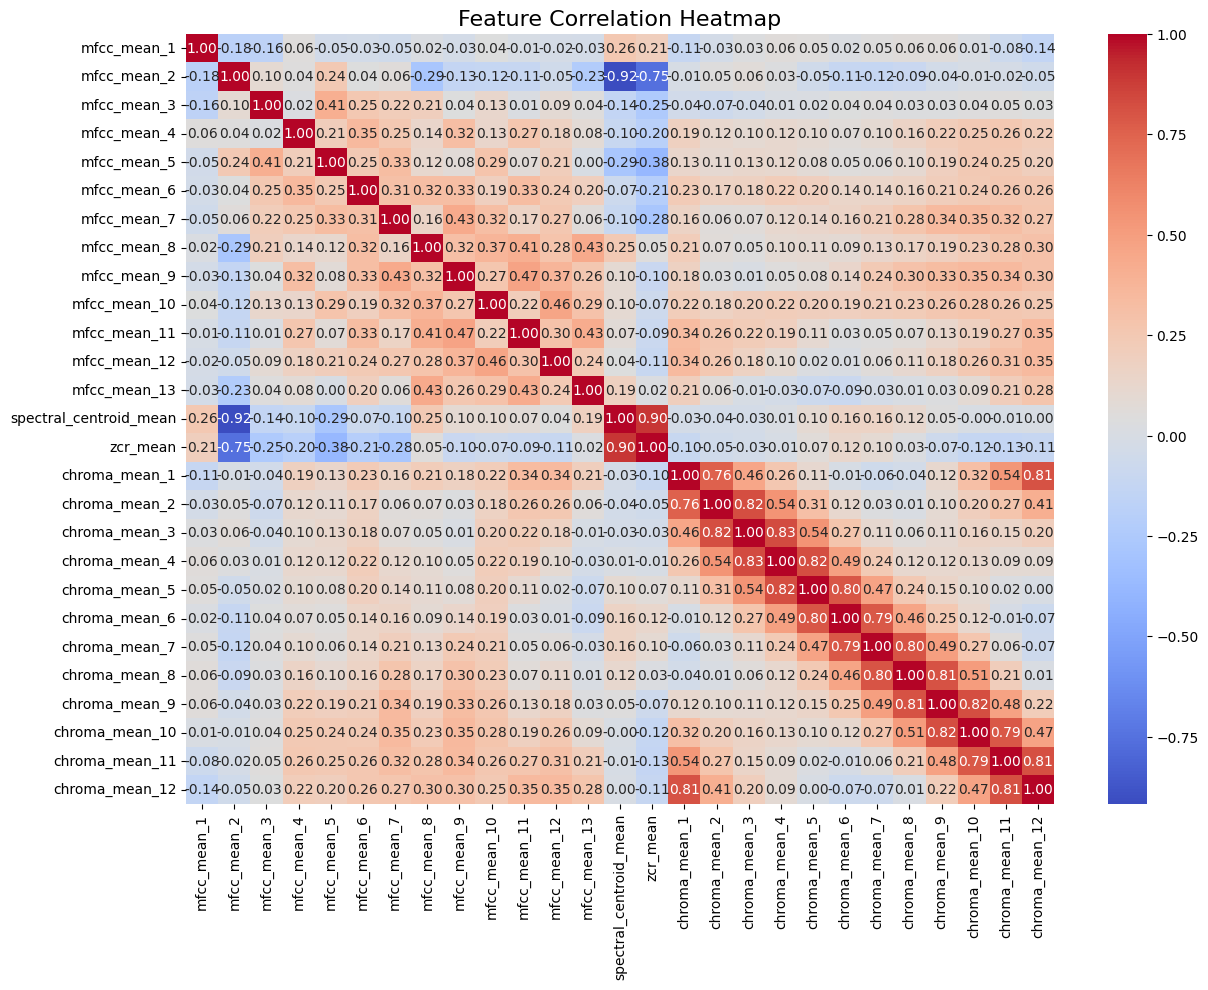

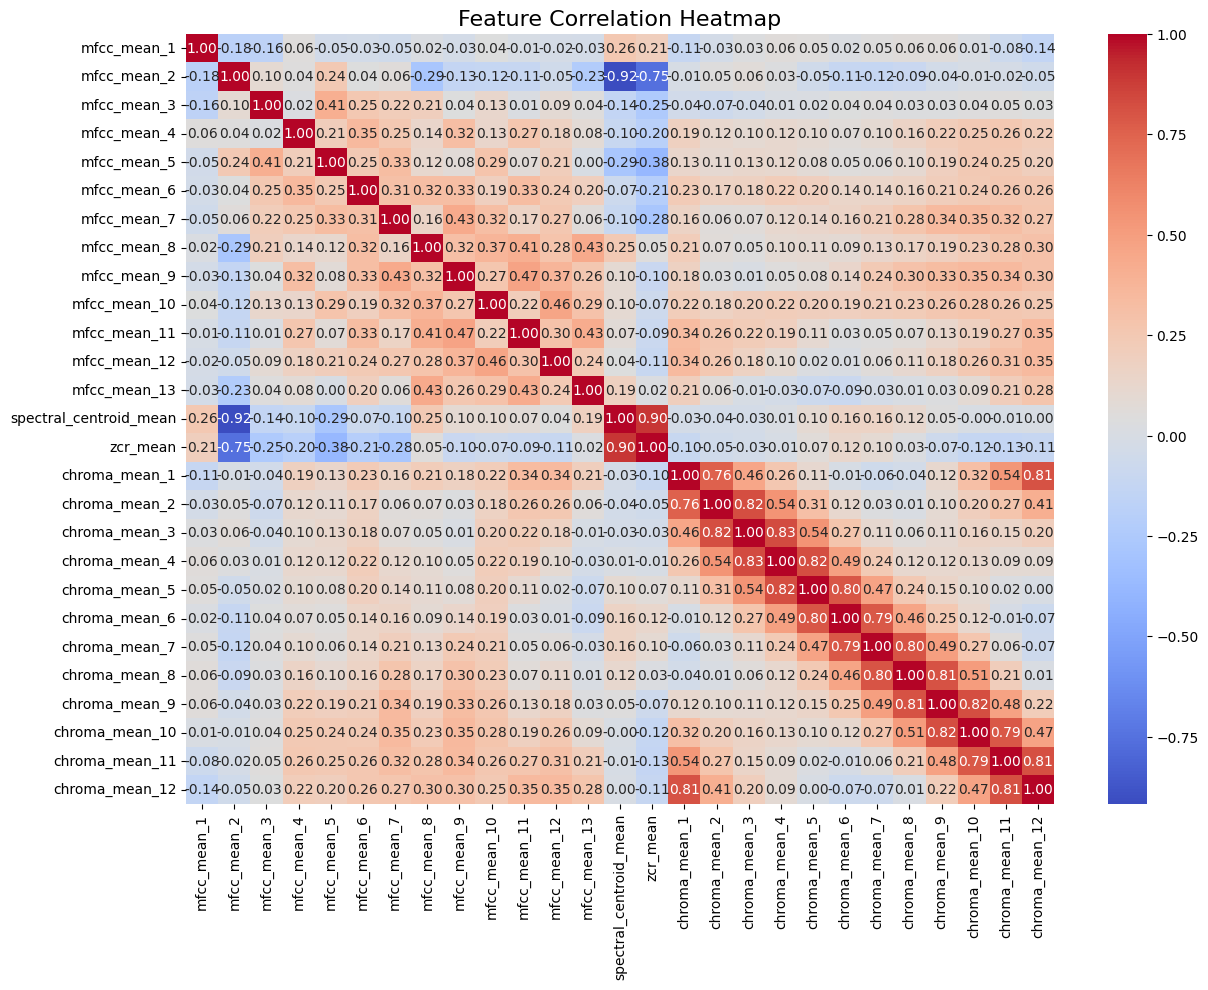

In [ ]:
# Vérifier si le DataFrame est défini et contient des valeurs
if "df" in locals() and not df.empty:
    # Supprimer la colonne "audio_path" :parce qu'elle contient des valeurs non numériques (des chaînes de caractères représentant les noms de fichiers audio)
    numeric_df = df.drop(columns=["speaker_id"], errors="ignore")

    # Vérifier qu'il reste des colonnes numériques pour la heatmap
    if not numeric_df.empty:
        plt.figure(figsize=(14, 10))
        sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
        plt.title("Feature Correlation Heatmap", fontsize=16)
        plt.show()
    else:
        print("❌ Aucune donnée numérique disponible pour générer la heatmap.")
else:
    print("❌ Le DataFrame est vide ou non défini. Vérifiez l'extraction des features.")

# Interpétation  Heatmap :
1. MFCCs (mfcc_mean_1 à mfcc_mean_13) :

Certains MFCCs ont des corrélations fortes entre eux (> 0.5 ou < -0.5) =>  **informations redondantes**!

2. Spectral Centroid :

faiblement ou modérément corrélé aux autres features => apporte une **information unique**

3. Zero Crossing Rate (ZCR) :     

Il montre des corrélations négatives avec certains MFCCs : quand le ZCR augmente, certaines valeurs des MFCCs diminuent

4. Chroma Features (chroma_mean_1 à chroma_mean_12) :

fortement corrélées entre elles (> 0.7 ou < -0.7)=> **redondance**




=> On va calculer la **variance** de chaque feature pour voir lesquelles sont les plus **informatives** :

* Une **faible variance** signifie que la feature ne change pas beaucoup d’un échantillon à l’autre → peu informative.

* Une **grande variance** signifie que la feature contient plus d’information discriminante ( aide à différencier ou classer correctement les données)

**=> une feature est discriminante si elle permet de distinguer les différents locuteurs.**




# **II. Test_dataset**

In [ ]:
print(test_dataset[0])

In [ ]:
# Extraire les features pour le test
test_features = []
test_labels = []

for idx in range(len(test_dataset)):
    try:
        waveform, sample_rate, _, speakertest_id, _, _ = test_dataset[idx]

        if waveform.numel() == 0:
            warnings.warn(f"⚠️ Audio vide à l'index {idx}")
            continue

        # Convertir en numpy
        y = waveform.numpy().flatten()

        # Supprimer les silences
        y_trimmed = remove_silence(y)

        # Extraire les features
        feature_vector = extract_features(y_trimmed, sample_rate)

        if feature_vector is not None and feature_vector.shape[0] == 27:
            test_features.append(feature_vector)
            test_labels.append(speakertest_id)

    except Exception as e:
        warnings.warn(f"⚠️ Erreur lors du traitement du fichier à l'index {idx}: {e}")
        continue
    # Vérifier qu'on a bien extrait des features avant d'enregistrer
if len(test_features) > 0:
    # Définir les noms des colonnes
    mfcc_columns = [f"mfcc_mean_{i+1}" for i in range(13)]
    chroma_columns = [f"chroma_mean_{i+1}" for i in range(12)]

    # Création du DataFrame avec les noms des features
    column_test = mfcc_columns + ["spectral_centroid_mean", "zcr_mean"] + chroma_columns + ["speakertest_id"]

    # Création du DataFrame
    df_test = pd.DataFrame(test_features, columns=column_test[:-1])
    df_test["speakertest_id"] = test_labels  # Associer les labels des locuteurs

    # Sauvegarde en CSV
    df_test.to_csv("extracted_features_test.csv", index=False)
    print("✅ Extraction des features terminée. Résultats enregistrés dans 'extracted_features_test.csv'")
else:
    print("❌ Aucune feature extraite. Vérifiez les fichiers audio.")




In [ ]:
df_test.describe()

In [ ]:
df_test.shape

In [ ]:
# Vérification du nombre d'échantillons par locuteur
locuteurs_counts_test = df_test['speakertest_id'].value_counts()
locuteurs_counts_test[locuteurs_counts_test == 1]
locuteurs_counts_test


In [ ]:
# missing values
print(df_test.isnull().sum())

In [ ]:
#Checking the feature distributions


df_test.hist(figsize=(18, 12), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

In [ ]:
# Vérifier si le DataFrame est défini et contient des valeurs
if "df_test" in locals() and not df_test.empty:
    # Supprimer la colonne "audio_path" :parce qu'elle contient des valeurs non numériques (des chaînes de caractères représentant les noms de fichiers audio)
    numeric_df_test = df_test.drop(columns=["speakertest_id"], errors="ignore")

    # Vérifier qu'il reste des colonnes numériques pour la heatmap
    if not numeric_df_test.empty:
        plt.figure(figsize=(14, 10))
        sns.heatmap(numeric_df_test.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
        plt.title("Feature Correlation Heatmap(test)", fontsize=16)
        plt.show()
    else:
        print("❌ Aucune donnée numérique disponible pour générer la heatmap.")
else:
    print("❌ Le DataFrame est vide ou non défini. Vérifiez l'extraction des features.")

#III.Filtred data train set

In [ ]:
# Extraire les features pour les locuteurs filtrés uniquement : Speakers avec au moins 100 fichiers audio
features_filtered = []
labels_filtered = []

for idx in range(len(train_dataset)):
    try:
        waveform, sample_rate, _, speaker_id, _, _ = train_dataset[idx]

        if speaker_id not in selected_speakers:
            continue  # Skip les locuteurs avec moins de 100 fichiers

        if waveform.numel() == 0:
            warnings.warn(f"⚠️ Audio vide à l'index {idx}")
            continue

        y = waveform.numpy().flatten()
        y_trimmed = remove_silence(y)
        feature_vector = extract_features(y_trimmed, sample_rate)

        if feature_vector is not None and feature_vector.shape[0] == 27:  # 13 MFCC + 1 SC + 1 ZCR + 12 Chroma
            features_filtered.append(feature_vector)
            labels_filtered.append(speaker_id)

    except Exception as e:
        warnings.warn(f"⚠️ Erreur lors du traitement du fichier à l'index {idx}: {e}")
        continue

# Étape 3 : Enregistrement
if len(features_filtered) > 0:
    mfcc_columns = [f"mfcc_mean_{i+1}" for i in range(13)]
    chroma_columns = [f"chroma_mean_{i+1}" for i in range(12)]
    column_names = mfcc_columns + ["spectral_centroid_mean", "zcr_mean"] + chroma_columns + ["speaker_id"]

    df_filtered = pd.DataFrame(features_filtered, columns=column_names[:-1])
    df_filtered["speaker_id"] = labels_filtered

    df_filtered.to_csv("extracted_features_filtered.csv", index=False)
    print("✅ Features extraites uniquement pour les locuteurs sélectionnés. Résultats dans 'extracted_features_filtered.csv'")
else:
    print("❌ Aucune feature extraite. Vérifiez les fichiers audio ou les critères de sélection.")

✅ Features extraites uniquement pour les locuteurs sélectionnés. Résultats dans 'extracted_features_filtered.csv'


#IV. Le nombre de fichiers audio que le plus grand nombre de speakers : 113

In [ ]:
# Extraction des features
features_target = []
labels_target = []

for idx in range(len(train_dataset)):
    try:
        waveform, sample_rate, _, speaker_id, _, _ = train_dataset[idx]

        if speaker_id not in target_speakers:
            continue  # Ignorer les autres speakers

        if waveform.numel() == 0:
            warnings.warn(f"⚠️ Audio vide à l'index {idx}")
            continue

        y = waveform.numpy().flatten()
        y_trimmed = remove_silence(y)
        feature_vector = extract_features(y_trimmed, sample_rate)

        if feature_vector is not None and feature_vector.shape[0] == 27:  # 13 MFCC + 1 SC + 1 ZCR + 12 Chroma
            features_target.append(feature_vector)
            labels_target.append(speaker_id)

    except Exception as e:
        warnings.warn(f"⚠️ Erreur à l'index {idx} : {e}")
        continue

# Étape 5 : Sauvegarde
if len(features_target) > 0:
    mfcc_columns = [f"mfcc_mean_{i+1}" for i in range(13)]
    chroma_columns = [f"chroma_mean_{i+1}" for i in range(12)]
    column_names = mfcc_columns + ["spectral_centroid_mean", "zcr_mean"] + chroma_columns + ["speaker_id"]

    df_target = pd.DataFrame(features_target, columns=column_names[:-1])
    df_target["speaker_id"] = labels_target

    df_target.to_csv("extracted_features_most_common_count.csv", index=False)
    print("✅ Features extraites et enregistrées dans 'extracted_features_most_common_count.csv'")
else:
    print("❌ Aucune feature extraite.")

✅ Features extraites et enregistrées dans 'extracted_features_most_common_count.csv'


#**GMM**

# 2 data bases :

In [ ]:
# Séparation des features et des labels
train_features = df.iloc[:, :-1].values  # Toutes les colonnes sauf la dernière
train_labels = df.iloc[:, -1].astype(str).values  # Convertir les labels en str
test_features = df_test.iloc[:, :-1].values
test_labels = df_test.iloc[:, -1].astype(str).values  # Convertir les labels en str

In [ ]:
# Récupérer les IDs des locuteurs dans les datasets
train_speaker_ids = np.unique(train_labels)
test_speaker_ids = np.unique(test_labels)

# Identifier les locuteurs communs entre l'entraînement et le test
common_speakers = np.intersect1d(train_speaker_ids, test_speaker_ids)

# Afficher les résultats
if len(common_speakers) > 0:
    print(f"Locuteurs communs entre les datasets d'entraînement et de test : {common_speakers}")
else:
    print("Aucun locuteur commun entre les datasets d'entraînement et de test.")


Aucun locuteur commun entre les datasets d'entraînement et de test.


In [ ]:
# Obtenir la liste unique des locuteurs pour l'entrainement
speakers = df['speaker_id'].unique()
models = {}

In [ ]:
speakers

array([ 103, 1034, 1040, 1069, 1081, 1088, 1098, 1116,  118, 1183, 1235,
       1246,  125, 1263, 1334, 1355, 1363, 1447, 1455,  150, 1502, 1553,
       1578, 1594, 1624,  163, 1723, 1737, 1743, 1841, 1867, 1898,   19,
       1926,  196, 1963, 1970,  198, 1992,  200, 2002, 2007,  201, 2092,
        211, 2136, 2159, 2182, 2196,  226, 2289,  229,  233, 2384, 2391,
       2416, 2436,  248,  250, 2514, 2518,  254,   26, 2691,   27, 2764,
       2817, 2836, 2843,  289, 2893, 2910, 2911, 2952,  298, 2989,  302,
        307,  311, 3112, 3168,   32, 3214,  322, 3235, 3240, 3242, 3259,
        328,  332, 3374, 3436, 3440, 3486, 3526, 3607, 3664, 3699, 3723,
        374, 3807, 3830, 3857, 3879,   39, 3947, 3982, 3983,   40, 4014,
       4018,  403,  405, 4051, 4088,  412, 4137, 4160, 4195, 4214,  426,
       4267, 4297, 4340, 4362, 4397, 4406,  441, 4441,  445,  446, 4481,
        458,  460, 4640, 4680, 4788,  481, 4813, 4830, 4853, 4859, 4898,
       5022, 5049, 5104, 5163, 5192, 5322, 5339, 53

In [ ]:
# Entraînement d'un modèle GMM par locuteur
for speaker in speakers:
    speaker_data = df.loc[df['speaker_id'] == speaker]  # Extraire les données du locuteur
    speaker_data = speaker_data.drop('speaker_id', axis=1) #supp l'id bch yok3ed aandi juste les 27 featres !!!
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(speaker_data)
    models[str(speaker)] = gmm

In [ ]:
speaker_data

,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12
28426,-372.420044,66.252960,-8.359868,19.735231,-8.246833,-1.970627,-17.439541,-17.374155,-6.585636,-7.986984,...,0.368919,0.398245,0.467986,0.545629,0.517042,0.495708,0.505389,0.379642,0.309470,0.268488
28427,-351.390228,75.441757,-22.200945,35.462597,-8.401279,-4.585401,-21.407402,-16.656549,-5.283918,-14.115705,...,0.356548,0.353463,0.372463,0.466745,0.432575,0.455416,0.498929,0.439011,0.335414,0.309571
28428,-332.070374,80.290993,-19.344448,29.849930,-9.268520,-7.161563,-19.773916,-17.327608,-10.100307,-13.030109,...,0.321659,0.327075,0.377268,0.473651,0.434807,0.474262,0.507992,0.427947,0.348696,0.298102
28429,-346.561279,82.620125,-24.988556,36.562950,-2.142133,-8.649806,-24.920378,-22.114649,-7.941895,-13.590810,...,0.337841,0.391063,0.403411,0.434732,0.456149,0.468286,0.482831,0.470525,0.371391,0.288351
28430,-368.334991,94.902992,-21.492365,17.302885,-12.500595,-4.778059,-17.893723,-17.664011,-4.438100,-14.533971,...,0.356841,0.336667,0.433601,0.465407,0.470174,0.489505,0.489066,0.443596,0.349072,0.290804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28534,-297.504028,92.721603,-26.162539,27.721846,-17.616207,-6.319375,-21.522253,-18.606705,-0.992417,-20.245613,...,0.367163,0.294912,0.285803,0.349510,0.503949,0.545909,0.430670,0.404517,0.449435,0.396268
28535,-401.941742,97.691849,-19.207779,22.522438,-11.462331,-8.070600,-13.576226,-11.761776,-0.597179,-16.846867,...,0.400755,0.410919,0.390141,0.444728,0.535307,0.627280,0.559598,0.467033,0.411069,0.401373
28536,-361.874329,96.251549,-18.495451,16.325739,-9.978543,-6.689950,-14.944684,-16.979944,1.618641,-17.544832,...,0.389613,0.363179,0.354754,0.388835,0.545458,0.589446,0.521651,0.405276,0.335217,0.312621
28537,-341.771332,83.448830,-13.465381,23.734880,-13.090948,-6.440833,-15.758504,-13.525767,-2.398408,-18.736095,...,0.324113,0.329645,0.316195,0.380669,0.502936,0.610506,0.501798,0.425516,0.375036,0.360777


# Attention

**df['speaker_id' == speaker]** est incorrect car ('speaker_id' == speaker) renvoie un booléen (False), et df[False] déclenche un KeyError.

**df.loc[df['speaker_id'] == speaker]** sélectionne correctement les lignes où speaker_id correspond au speaker.

In [ ]:
y_pred=[]
scores_list =[]
true_labels =[]
for i, sample in enumerate(test_features):
    sample = sample.reshape(1, -1)  # Assure-toi que sample est 2D avant de l'entrer dans le modèle

    # Calculer les scores pour chaque locuteur
    scores = {str(speaker): models[str(speaker)].score(sample) for speaker in speakers}

    # Prédiction du locuteur
    predicted_speaker = max(scores, key=scores.get)

    y_pred.append(predicted_speaker)
    scores_list.append(scores[predicted_speaker])
    true_labels.append(1 if predicted_speaker == test_labels[i] else 0)

# Calcul de l'accuracy
y_pred = np.array(y_pred)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted wit

In [ ]:
print("Scores list:", scores_list)
print("True labels:", true_labels)


Scores list: [np.float64(-29.089847737984435), np.float64(-59.167822606867844), np.float64(-60.859636445508855), np.float64(-90.69282286669753), np.float64(-28.72532060560849), np.float64(-54.57483030510867), np.float64(-44.627916271432795), np.float64(-80.47099825159593), np.float64(-28.608666412119657), np.float64(-36.62636821284262), np.float64(-74.16069909732742), np.float64(-41.347663377640245), np.float64(-29.34449962127641), np.float64(-23.94009871863982), np.float64(-77.84244557605666), np.float64(-51.77028304216109), np.float64(-61.8704880395416), np.float64(-62.14641753665798), np.float64(-31.09040110813689), np.float64(-17.329571129237884), np.float64(-30.232411890320385), np.float64(-37.93923733494577), np.float64(-24.673968969908287), np.float64(-35.80510649440578), np.float64(-38.26916839389454), np.float64(-45.00336522825541), np.float64(-84.57636646314084), np.float64(-91.70537713528546), np.float64(-44.779888174967844), np.float64(-51.28995112459099), np.float64(-100.5

In [ ]:
# Calcul de l'accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calcul de l'EER (Equal Error Rate)
fpr, tpr, thresholds = roc_curve(true_labels, scores_list)
eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
print(f"Equal Error Rate (EER): {eer * 100:.2f}%")


Accuracy: 0.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: All-NaN slice encountered

Lorsqu'on évalue un modèle binaire (par exemple, dans la reconnaissance de locuteur), il y a une courbe ROC qui montre le compromis entre taux de faux positifs (FPR) et taux de vrais positifs (TPR) pour différents seuils de décision.

L'EER est définie comme le point sur cette courbe ROC où les taux de faux positifs (FPR) et de faux négatifs (FNR, équivalents des faux positifs mais dans le cas des négatifs) sont égaux. Autrement dit, à ce seuil, les erreurs de type faux positifs et faux négatifs ont la même probabilité. Cela correspond à un compromis idéal où le modèle fait des erreurs avec une fréquence similaire, tant pour les positifs que pour les négatifs.

Pourquoi utiliser l'EER ?
L'EER donne une mesure globale de la performance d'un modèle en équilibrant les erreurs dans les deux classes (positifs et négatifs). Si l'EER est faible, cela signifie que le modèle est relativement bon pour classifier correctement les deux classes. Si l'EER est élevé, cela indique que le modèle a un mauvais compromis entre les erreurs positives et négatives.

Comment le calculer ?
Courbe ROC (Receiver Operating Characteristic) :
Une courbe ROC est tracée pour un modèle de classification binaire, où l'axe des x représente le Taux de Faux Positifs (FPR) et l'axe des y représente le Taux de Vrais Positifs (TPR).

Chercher le point d'intersection :
L'EER est déterminé en cherchant le seuil de décision où FPR = FNR. Ce point est où les deux courbes (FPR et TPR) se croisent.

FPR (False Positive Rate) = Faux Positifs / (Faux Positifs + Vrais Négatifs)

FNR (False Negative Rate) = Faux Négatifs / (Vrais Positifs + Faux Négatifs)

Calcul du EER :
Une fois que tu as les courbes ROC, tu peux trouver le seuil où les erreurs sont égales (où FPR = FNR). Le EER est la moyenne des valeurs de FPR et TPR à ce point.

Formellement :

EER
=
FPR
+
(
1
−
TPR
)
2
EER=
2
FPR+(1−TPR)
​

Ce calcul reflète le compromis entre les erreurs de type positif et négatif.

# data_train seulement :

In [ ]:
# Séparation des features et des labels
x = df.iloc[:, :-1].values  # Toutes les colonnes sauf la dernière
labels = df.iloc[:, -1].values  # Dernière colonne (ID locuteur)

In [ ]:
# Séparer les locuteurs en ensembles d'entraînement et de test
train_speakers, test_speakers = train_test_split(speakers, test_size=0.2, random_state=42)

In [ ]:
# 'features' et 'labels' sont des numpy arrays
features = np.array(x)
labels = np.array(labels)


In [ ]:
labels.shape

(28539,)

In [ ]:
features.shape

(28539, 27)

In [ ]:
# Filtrer les features en fonction des locuteurs dans les ensembles d'entraînement et de test
train_mask = np.isin(labels, train_speakers)  # Créer un masque pour les locuteurs d'entraînement
test_mask = np.isin(labels, test_speakers)  # Créer un masque pour les locuteurs de test

train_f = x[train_mask]
train_l = labels[train_mask]
test_f = x[test_mask]
test_l = labels[test_mask]

In [ ]:
# Entraîner un modèle GMM pour chaque locuteur dans l'ensemble d'entraînement
models2 = {}

for speaker in train_speakers:
    speaker2_data = train_f[train_l == speaker]  # Extraire les données du locuteur
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(speaker2_data)
    models2[speaker] = gmm

In [ ]:
# Prédiction sur l'ensemble de test
y_ = []
test_scores_list = []

for i, sample in enumerate(test_f):
    # Calcul des scores pour chaque locuteur
    scores2 = {speaker: models2[speaker].score([sample]) for speaker in train_speakers}  # Test uniquement sur les locuteurs d'entraînement
    predicted_y = max(scores2, key=scores2.get)  # Locuteur avec le score maximum
    y_.append(predicted_y)
    test_scores_list.append(scores2[predicted_y])

# Convertir en array numpy pour calculs
y_pred2 = np.array(y_)

In [ ]:
scores2

{np.int64(5688): np.float64(-283.23976439725016),
 np.int64(78): np.float64(-780.579512619133),
 np.int64(3830): np.float64(-335.73602504975),
 np.int64(481): np.float64(-404.40024518150216),
 np.int64(2817): np.float64(-186.99181769749404),
 np.int64(8014): np.float64(-580.3857644254614),
 np.int64(6563): np.float64(-549.5356755760516),
 np.int64(7780): np.float64(-402.7081219060684),
 np.int64(7302): np.float64(-280.45931855305736),
 np.int64(3664): np.float64(-857.2018105038372),
 np.int64(8226): np.float64(-825.1036539491927),
 np.int64(4014): np.float64(-268.26836868931036),
 np.int64(5390): np.float64(-626.7250546823653),
 np.int64(39): np.float64(-367.8105807820273),
 np.int64(7635): np.float64(-223.13409069712122),
 np.int64(4859): np.float64(-400.35921464321495),
 np.int64(5703): np.float64(-1203.8323754118067),
 np.int64(7148): np.float64(-195.10319074249065),
 np.int64(289): np.float64(-635.6066873431104),
 np.int64(4160): np.float64(-718.2622680658933),
 np.int64(2989): np.

In [ ]:
y_pred2

array([8465, 8465, 6385, ..., 1898, 1898, 4088])

In [ ]:
print(f"Speakers dans models: {list(models2.keys())}")
print(f"Speakers dans train: {np.unique(train_l)}")
print(f"Speakers dans test: {np.unique(test_l)}")


Speakers dans models: [np.int64(5688), np.int64(78), np.int64(3830), np.int64(481), np.int64(2817), np.int64(8014), np.int64(6563), np.int64(7780), np.int64(7302), np.int64(3664), np.int64(8226), np.int64(4014), np.int64(5390), np.int64(39), np.int64(7635), np.int64(4859), np.int64(5703), np.int64(7148), np.int64(289), np.int64(4160), np.int64(2989), np.int64(403), np.int64(8465), np.int64(6529), np.int64(8609), np.int64(669), np.int64(1841), np.int64(441), np.int64(4898), np.int64(5192), np.int64(1088), np.int64(2436), np.int64(7264), np.int64(5456), np.int64(887), np.int64(2764), np.int64(4788), np.int64(4397), np.int64(8629), np.int64(8312), np.int64(1898), np.int64(125), np.int64(1963), np.int64(1743), np.int64(201), np.int64(40), np.int64(1578), np.int64(3486), np.int64(6078), np.int64(405), np.int64(229), np.int64(3607), np.int64(5049), np.int64(7226), np.int64(302), np.int64(2007), np.int64(4088), np.int64(5652), np.int64(311), np.int64(5322), np.int64(1723), np.int64(8747), np.

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binariser les labels
test_labels_bin = label_binarize(test_l, classes=np.unique(train_l))

# Convertir les scores en format compatible
test_scores_bin = np.array([models[speaker].score_samples(test_f) for speaker in np.unique(train_l)]).T

# Calcul du score AUC (Area Under Curve) pour évaluer la performance
roc_auc = roc_auc_score(test_labels_bin, test_scores_bin, average="macro", multi_class="ovr")
print(f"ROC AUC Score: {roc_auc:.2f}")


KeyError: np.int64(19)

In [ ]:
# Calcul de l'accuracy sur les données de test
test_accuracy = accuracy_score(test_l, y_pred2)
print(f"Accuracy sur la base de test: {test_accuracy * 100:.2f}%")

# Calcul de l'EER (Equal Error Rate) sur les données de test
fpr_test, tpr_test, thresholds_test = roc_curve(test_l, test_scores_list)
eer_test_index = np.nanargmin(np.abs(fpr_test - (1 - tpr_test)))
eer_test = (fpr_test[eer_test_index] + (1 - tpr_test[eer_test_index])) / 2
print(f"Equal Error Rate (EER) sur la base de test: {eer_test * 100:.2f}%")

jarebbb : les lignes kol fi oudh id yhotthom nwemer , baaed ydour alihom kol w yaamel des clusters kol lignes ychoufha tabaa ama id yaani ylamed les num de la meme perso w baaed bel speker_id ychouf l prediction te3o cv ou non yaaml evaluation !

alka hall leli lfour accuracy 0 ya rabi !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! fama faute fi calcul score je pense

In [ ]:
#gmm correcte !!!!!!!!

In [ ]:
# Function to find the best n_components using BIC
def select_best_n_components(X, max_components=10):
    bic_scores = []
    components_range = range(1, max_components + 1)

    for n in components_range:
        gmm = GaussianMixture(n_components=n, covariance_type='diag', max_iter=200, random_state=42)
        gmm.fit(X)                                  # the covariance_type='diag' param means that the model assumes the features are uncorrelated and only considers the variances of each feature.
        bic_scores.append(gmm.bic(X))               #the max_iter means that the algorithm will perform up to 200 iterations to converge to a solution. If the algorithm converges before reaching 200 iterations, it will stop earlier.

    best_n_bic = components_range[np.argmin(bic_scores)]
    return best_n_bic

In [ ]:
import pickle

In [ ]:
X = df.drop(columns=["speaker_id"]).values  # Features
y = df["speaker_id"].values  # Labels des locuteurs

# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Dictionnaire pour stocker les modèles GMM entraînés
gmm_models = {}

# Obtenir les identifiants uniques des locuteurs
unique_speakers = np.unique(y_train)

# Entraîner un GMM pour chaque locuteur
for speaker_id in unique_speakers:
    print(f"🔹 Training GMM for Speaker {speaker_id}...")

    # Récupérer les features de ce locuteur
    speaker_features = X_train[y_train == speaker_id]

    # Sélection du meilleur n_components
    best_n = select_best_n_components(speaker_features, max_components=10)
    print(f"🔹 Optimal n_components for Speaker {speaker_id}: {best_n}")

    # Entraîner le GMM
    gmm = GaussianMixture(n_components=best_n, covariance_type='diag', max_iter=200, random_state=42)
    gmm.fit(speaker_features)

    # Stocker le modèle
    gmm_models[speaker_id] = gmm

# Sauvegarder les modèles entraînés
with open("gmm_models.pkl", 'wb') as f:
    pickle.dump(gmm_models, f)

print("✅ GMM Models trained with optimal n_components and saved successfully!")

🔹 Training GMM for Speaker 19...


NameError: name 'GaussianMixture' is not defined

    Prédit le locuteur en fonction des features extraites.
    
    Args:
        feature_vector (numpy array): Features extraites de l'échantillon test.
        gmm_models (dict): Dictionnaire des modèles GMM entraînés pour chaque locuteur.
    
    Returns:
        str: L'ID du locuteur prédit.

In [ ]:
# Fonction de prédiction du locuteur
def predict_speaker(feature_vector, gmm_models):

    log_likelihoods = {speaker: gmm.score(feature_vector.reshape(1, -1)) for speaker, gmm in gmm_models.items()}
    return max(log_likelihoods, key=log_likelihoods.get)

In [ ]:
# Évaluer la précision du modèle GMM
correct_predictions = 0

for i in range(len(X_test)):
    feature_vector = X_test[i]  # Extraire les features de l'échantillon test
    true_speaker = y_test[i]  # Label réel du locuteur
    predicted_speaker = predict_speaker(feature_vector.reshape(1, -1), gmm_models)

    if predicted_speaker == true_speaker:
        correct_predictions += 1

# Calcul et affichage de la précision
accuracy = correct_predictions / len(X_test) * 100
print(f"🔹 GMM Test Accuracy: {accuracy:.2f}%")

🔹 GMM Test Accuracy: 95.87%


#Filtered data tarin set

In [ ]:
# Séparer les features et les labels
X_fil = df_filtered.drop(columns=["speaker_id"]).values
y_fil = df_filtered["speaker_id"].values

# Division en données d'entraînement et de test
X_trainf, X_testf, y_trainf, y_testf = train_test_split(
    X_fil, y_fil, test_size=0.2, stratify=y_fil, random_state=42
)

In [ ]:
# Dictionnaire pour stocker les modèles GMM
gmm_models = {}

# Liste des locuteurs uniques
unique_speakers = np.unique(y_trainf)

# Entraîner un GMM par locuteur
for speaker_id in unique_speakers:
    print(f"🔹 Training GMM for Speaker {speaker_id}...")

    # Récupérer les features du locuteur
    speaker_features = X_trainf[y_trainf == speaker_id]

    # Trouver le meilleur nombre de composants
    best_n = select_best_n_components(speaker_features, max_components=10)
    print(f"🔹 Optimal n_components for Speaker {speaker_id}: {best_n}")

    # Entraîner le modèle GMM
    gmm = GaussianMixture(n_components=best_n, covariance_type='diag', max_iter=200, random_state=42)
    gmm.fit(speaker_features)

    # Sauvegarder le modèle
    gmm_models[speaker_id] = gmm

# Sauvegarde des modèles
with open("gmm_models_filtered.pkl", "wb") as f:
    pickle.dump(gmm_models, f)

print("✅ GMM models trained and saved for filtered dataset.")

🔹 Training GMM for Speaker 19...


NameError: name 'select_best_n_components' is not defined

In [ ]:
# Évaluation du modèle
correct_predictions = 0

for i in range(len(X_testf)):
    feature_vector = X_testf[i]
    true_speaker = y_testf[i]
    predicted_speaker = predict_speaker(feature_vector, gmm_models)

    if predicted_speaker == true_speaker:
        correct_predictions += 1

accuracy = correct_predictions / len(X_testf) * 100
print(f"🔹 GMM Test Accuracy on filtered dataset: {accuracy:.2f}%")

🔹 GMM Test Accuracy on filtered dataset: 95.99%


In [ ]:
X_fil.shape

(25956, 27)

In [ ]:
y_fil.shape

(25956,)

#113

In [ ]:
# Séparer les features et les labels
X_tar = df_target.drop(columns=["speaker_id"]).values
y_tar = df_target["speaker_id"].values

# Division en données d'entraînement et de test
X_traintar, X_testtar, y_traintar, y_testtar = train_test_split(
    X_tar, y_tar, test_size=0.2, stratify=y_tar, random_state=42
)

In [ ]:
# Dictionnaire pour stocker les modèles GMM
gmm_models_target = {}

# Liste des locuteurs uniques
unique_speakers = np.unique(y_traintar)

# Entraîner un GMM par locuteur
for speaker_id in unique_speakers:
    print(f"🔹 Training GMM for Speaker {speaker_id}...")

    # Récupérer les features du locuteur
    speaker_features_tar = X_traintar[y_traintar == speaker_id]

    # Trouver le meilleur nombre de composants
    best_n = select_best_n_components(speaker_features_tar , max_components=10)
    print(f"🔹 Optimal n_components for Speaker {speaker_id}: {best_n}")

    # Entraîner le modèle GMM
    gmm_tar = GaussianMixture(n_components=best_n, covariance_type='diag', max_iter=200, random_state=42)
    gmm_tar.fit(speaker_features_tar)

    # Sauvegarder le modèle
    gmm_models_target[speaker_id] = gmm_tar

# Sauvegarde des modèles
with open("gmm_models_target.pkl", "wb") as f:
    pickle.dump(gmm_models_target, f)

print("✅ GMM models trained and saved for target dataset.")

🔹 Training GMM for Speaker 298...
🔹 Optimal n_components for Speaker 298: 1
🔹 Training GMM for Speaker 302...
🔹 Optimal n_components for Speaker 302: 3
🔹 Training GMM for Speaker 374...
🔹 Optimal n_components for Speaker 374: 3
🔹 Training GMM for Speaker 911...
🔹 Optimal n_components for Speaker 911: 3
🔹 Training GMM for Speaker 2196...
🔹 Optimal n_components for Speaker 2196: 5
🔹 Training GMM for Speaker 3235...
🔹 Optimal n_components for Speaker 3235: 2
🔹 Training GMM for Speaker 3440...
🔹 Optimal n_components for Speaker 3440: 2
🔹 Training GMM for Speaker 3982...
🔹 Optimal n_components for Speaker 3982: 3
🔹 Training GMM for Speaker 3983...
🔹 Optimal n_components for Speaker 3983: 1
🔹 Training GMM for Speaker 5322...
🔹 Optimal n_components for Speaker 5322: 2
🔹 Training GMM for Speaker 5703...
🔹 Optimal n_components for Speaker 5703: 4
🔹 Training GMM for Speaker 5867...
🔹 Optimal n_components for Speaker 5867: 3
🔹 Training GMM for Speaker 6367...
🔹 Optimal n_components for Speaker 63

In [ ]:
# Évaluation du modèle
correct_predictions = 0

for i in range(len(X_testtar)):
    feature_vector = X_testtar[i]
    true_speaker = y_testtar[i]
    predicted_speaker = predict_speaker(feature_vector, gmm_models_target)

    if predicted_speaker == true_speaker:
        correct_predictions += 1

accuracy = correct_predictions / len(X_testf) * 100
print(f"🔹 GMM Test Accuracy on target dataset: {accuracy:.2f}%")

🔹 GMM Test Accuracy on target dataset: 6.43%
